In [20]:
from langchain_community.tools import WikipediaQueryRun,ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,AIMessage
import os   
import dotenv


from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send
from langchain_core.messages import HumanMessage, SystemMessage
import operator
from IPython.display import display,Image


In [2]:
dotenv.load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [3]:
from langchain_classic.agents import initialize_agent,AgentType
llm = ChatGroq(model = "llama-3.3-70b-versatile",verbose=True,max_tokens=500,api_key=GROQ_API_KEY)

In [5]:
class EmailState(TypedDict):
    email_text: str
    draft: str
    approved: bool

In [ ]:
def generate_draft(state: EmailState):
    prompt = f"Write a polite email reply to this:\n\n{state['email_text']}"
    state["draft"] = llm.invoke(prompt).content  
    return state

In [ ]:
def human_review(state: EmailState):
    print("\n--- Drafted Reply ---")
    print(state["draft"])
    decision = input("Approve this reply? (y/n): ").strip().lower()
    state["approved"] = (decision == "y")
    return state

In [16]:
def revise_draft(state: EmailState):
    if not state["approved"]:
        feedback = input("Enter feedback for the AI to improve the draft: ")
        prompt = (
            f"Revise this email reply based on feedback:\n\n"
            f"Original draft:\n{state['draft']}\n\nFeedback: {feedback}"
        )
        state["draft"] = llm.invoke(prompt).content
    return state


In [17]:
def finalize(state: EmailState):
    if state["approved"]:
        print("\nFinal approved reply:\n")
        print(state["draft"])
    else:
        print("\nThe draft was not approved.")
    return state

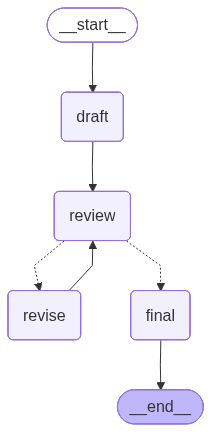

In [23]:
graph = StateGraph(EmailState)

graph.add_node("draft", generate_draft)
graph.add_node("review", human_review)
graph.add_node("revise", revise_draft)
graph.add_node("final", finalize)

graph.set_entry_point("draft")
graph.add_edge("draft", "review")
graph.add_conditional_edges(
    "review",
    lambda state: "final" if state["approved"] else "revise",
    {"final": "final", "revise": "revise"}
)
graph.add_edge("revise", "review")
graph.add_edge("final", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
initial_state: EmailState = {
    "email_text": "Hi, can we reschedule our meeting from Monday to Wednesday?",
    "draft": "",
    "approved": False,
}
app.invoke(initial_state)


--- Drafted Reply ---
Here is a polite email reply:

Hi,

Thank you for reaching out. I'd be happy to reschedule our meeting from Monday to Wednesday. Please let me know what time works best for you on Wednesday and I'll make sure to update my calendar accordingly.

Looking forward to hearing back from you and confirming the new time.

Best regards,
[Your Name]
---------------------

--- Drafted Reply ---
Here's a revised version with a dash of humor:

Hi,

Thanks for reaching out! I'm happy to reschedule our meeting from Monday to Wednesday. I'm assuming you didn't just want to get out of seeing me on Monday, but rather had a genuine scheduling conflict. Either way, Wednesday it is! Please let me know what time works best for you, and I'll make sure to update my calendar before I forget (which, let's be real, could happen at any moment).

Looking forward to hearing back from you and confirming the new time.

Best regards,
[Your Name]
---------------------

Final approved reply:

Here

{'email_text': 'Hi, can we reschedule our meeting from Monday to Wednesday?',
 'draft': "Here's a revised version with a dash of humor:\n\nHi,\n\nThanks for reaching out! I'm happy to reschedule our meeting from Monday to Wednesday. I'm assuming you didn't just want to get out of seeing me on Monday, but rather had a genuine scheduling conflict. Either way, Wednesday it is! Please let me know what time works best for you, and I'll make sure to update my calendar before I forget (which, let's be real, could happen at any moment).\n\nLooking forward to hearing back from you and confirming the new time.\n\nBest regards,\n[Your Name]",
 'approved': True}